In [1]:
import anndata
import h5py
import os
import pandas
import matplotlib.pyplot as plt
import numpy
import re
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as scs
from multiprocessing import Pool
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import seaborn as sns
import matplotlib as mpl
from functools import partial
import scanpy.external as sce

def read_mat(h5_con, mat_name):
    mat = scs.csc_matrix(
        (h5_con[mat_name]['data'][:], # Count values
         h5_con[mat_name]['indices'][:], # Row indices
         h5_con[mat_name]['indptr'][:]), # Pointers for column positions
        shape = tuple(h5_con[mat_name]['shape'][:]) # Matrix dimensions
    )
    return mat

def read_feats(h5_con, mat_name, name_col):
    feats = h5_con[mat_name]['features'][name_col][:]
    feats = [x.decode('UTF-8') for x in feats]
    return feats

def read_obs(h5con):
    bc = h5con['matrix']['barcodes'][:]
    bc = [x.decode('UTF-8') for x in bc]

    # Initialized the DataFrame with cell barcodes
    obs_df = pandas.DataFrame({ 'barcodes' : bc })

    # Get the list of available metadata columns
    obs_columns = h5con['matrix']['observations'].keys()

    # For each column
    for col in obs_columns:
        values = h5con['matrix']['observations'][col][:]
        # Check for byte storage
        if(isinstance(values[0], (bytes, bytearray))):
            # Decode byte strings
            values = [x.decode('UTF-8') for x in values]
        # Add column to the DataFrame
        obs_df[col] = values
    
    return obs_df

def read_scrublet(scrublet_file):
    scrub = pandas.read_csv(scrublet_file,
                            index_col = 0)
    scrub.index = scrub['barcodes']
    scrub = scrub.drop('barcodes', axis = 1)
    
    return scrub

def read_labels(labels_file):
    labels = pandas.read_csv(labels_file)
    labels.index = labels['barcodes']
    labels = labels.drop('barcodes', axis = 1)
    
    return labels

def build_adata(h5_file):
    h5_con = h5py.File(h5_file, mode = 'r')

    adt_mat = read_mat(h5_con, 'ADT')
    
    obs = read_obs(h5_con)
    obs = obs.reset_index(drop = True)
    barcodes = obs['barcodes']
    obs = obs.drop('barcodes', axis = 1)
    
    adts = read_feats(h5_con, 'ADT', 'id')
    h5_con.close()

    adata = sc.AnnData(X = adt_mat.toarray().T,
                           obs = obs)
    
    adata.var_names = adts
    adata.var_names_make_unique()

    adata.obs_names = barcodes
    

    return adata
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-p

In [2]:
meta_data=pd.read_csv('/home/workspace/private/bri_figure_all_files_test/jupyter/BRI_Figures_Final_V2/Figure5/03_TEAseq_PenSenior/meta_data_GEO.csv')
file_list=["/home/workspace/private/bri_figure_all_files_test/jupyter/BRI_Figures_Final_V2/Figure5/03_TEAseq_PenSenior/GSE214546_Data/"+x+'.h5' for x in meta_data['combined_sample_id']]

In [3]:
%%time
file_names= file_list
h5_list = []
with ThreadPoolExecutor(max_workers=16) as executor:
    future_to_file = {executor.submit(build_adata, file_name): file_name for file_name in file_names}
    for future in tqdm(as_completed(future_to_file), total=len(file_names)):
        result = future.result()
        if result is not None:
            h5_list.append(result)


  0%|          | 0/16 [00:00<?, ?it/s]/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
  6%|▋         | 1/16 [00:20<05:00, 20.01s/it]/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.

CPU times: user 1.81 s, sys: 583 ms, total: 2.39 s
Wall time: 20.8 s


In [4]:
adata_adt= anndata.concat(h5_list)

In [5]:
scATAC_Barcodes=pd.read_csv('barcodes_matching.csv')

In [6]:
overlap_barcodes = list(set(scATAC_Barcodes['barcodes_scRNA'].tolist()) & set(adata_adt.obs.index.tolist()))

In [7]:
adata_adt_filtered=adata_adt[overlap_barcodes,]

In [9]:
df=adata_adt_filtered.obs
df=df.reset_index()

In [10]:
df=df.merge(meta_data, on='pbmc_sample_id',how='left')
df=df.merge(scATAC_Barcodes, right_on='barcodes_scRNA',left_on='barcodes',how='left')



In [11]:
df.index=df['barcodes'].tolist()
adata_adt_filtered.obs=df

In [70]:
adata_adt_filtered=adata_adt_filtered[adata_adt_filtered.obs['AIFI_L3'].isin(['CM CD4 T cell','GZMB- CD27+ EM CD4 T cell','GZMB- CD27- EM CD4 T cell',
                                                                           'KLRF1- GZMB+ CD27- memory CD4 T cell'])]

In [12]:
sc.pp.calculate_qc_metrics(
    adata_adt_filtered,
    percent_top=(5, 10, 15),
    var_type="antibodies",
    inplace=True,
)

In [13]:
adata_adt_filtered.raw=adata_adt_filtered

adata_adt_filtered=clr_normalize_each_cell(adata_adt_filtered)

In [14]:
adata_adt_filtered.write_h5ad('ADT_All.h5ad')

In [72]:


sc.pp.highly_variable_genes(adata_adt_filtered,    n_top_genes=25)


adata_adt_filtered = adata_adt_filtered[:, adata_adt_filtered.var.highly_variable]
#sc.pp.log1p(adata_adt)

sc.pp.pca(adata_adt_filtered, n_comps=10)
sce.pp.harmony_integrate(adata_adt_filtered, 'batch_id',max_iter_harmony = 50)
sc.pp.neighbors(adata_adt_filtered, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=10)
#sc.pp.neighbors(adata_adt_filtered, n_neighbors=50,use_rep='X_pca', n_pcs=10)

sc.tl.umap(adata_adt_filtered)

/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
2025-01-09 17:00:31,680 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-09 17:00:34,467 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-09 17:00:34,728 - harmonypy - INFO - Iteration 1 of 50
2025-01-09 17:00:47,825 - harmonypy - INFO - Iteration 2 of 50
2025-01-09 17:01:00,872 - harmonypy - INFO - Iteration 3 of 50
2025-01-09 17:01:13,905 - harmonypy - INFO - Iteration 4 of 50
2025-01-09 17:01:26,951 - harmonypy - INFO - Iteration 5 of 50
2025-01-09 17:01:39,975 - harmonypy - INFO - Iteration 6 of 50
2025-01-09 17:01:53,082 - harmonypy - INFO - Iteration 7 of 50
2025-01-09 17:02:06,208 - harmonypy - INFO - Iteration 8 of 50
2025-01-09 17:02:19,083 - harmonypy - INFO - Iteration 9 of 50
2025-01-09 17

In [73]:
sc.tl.leiden(adata_adt_filtered,
             resolution=2,
             key_added="protein_leiden")

/tmp/ipykernel_2391/1253323383.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_adt_filtered,


In [74]:
plt.rcParams['figure.figsize'] = [5, 5]

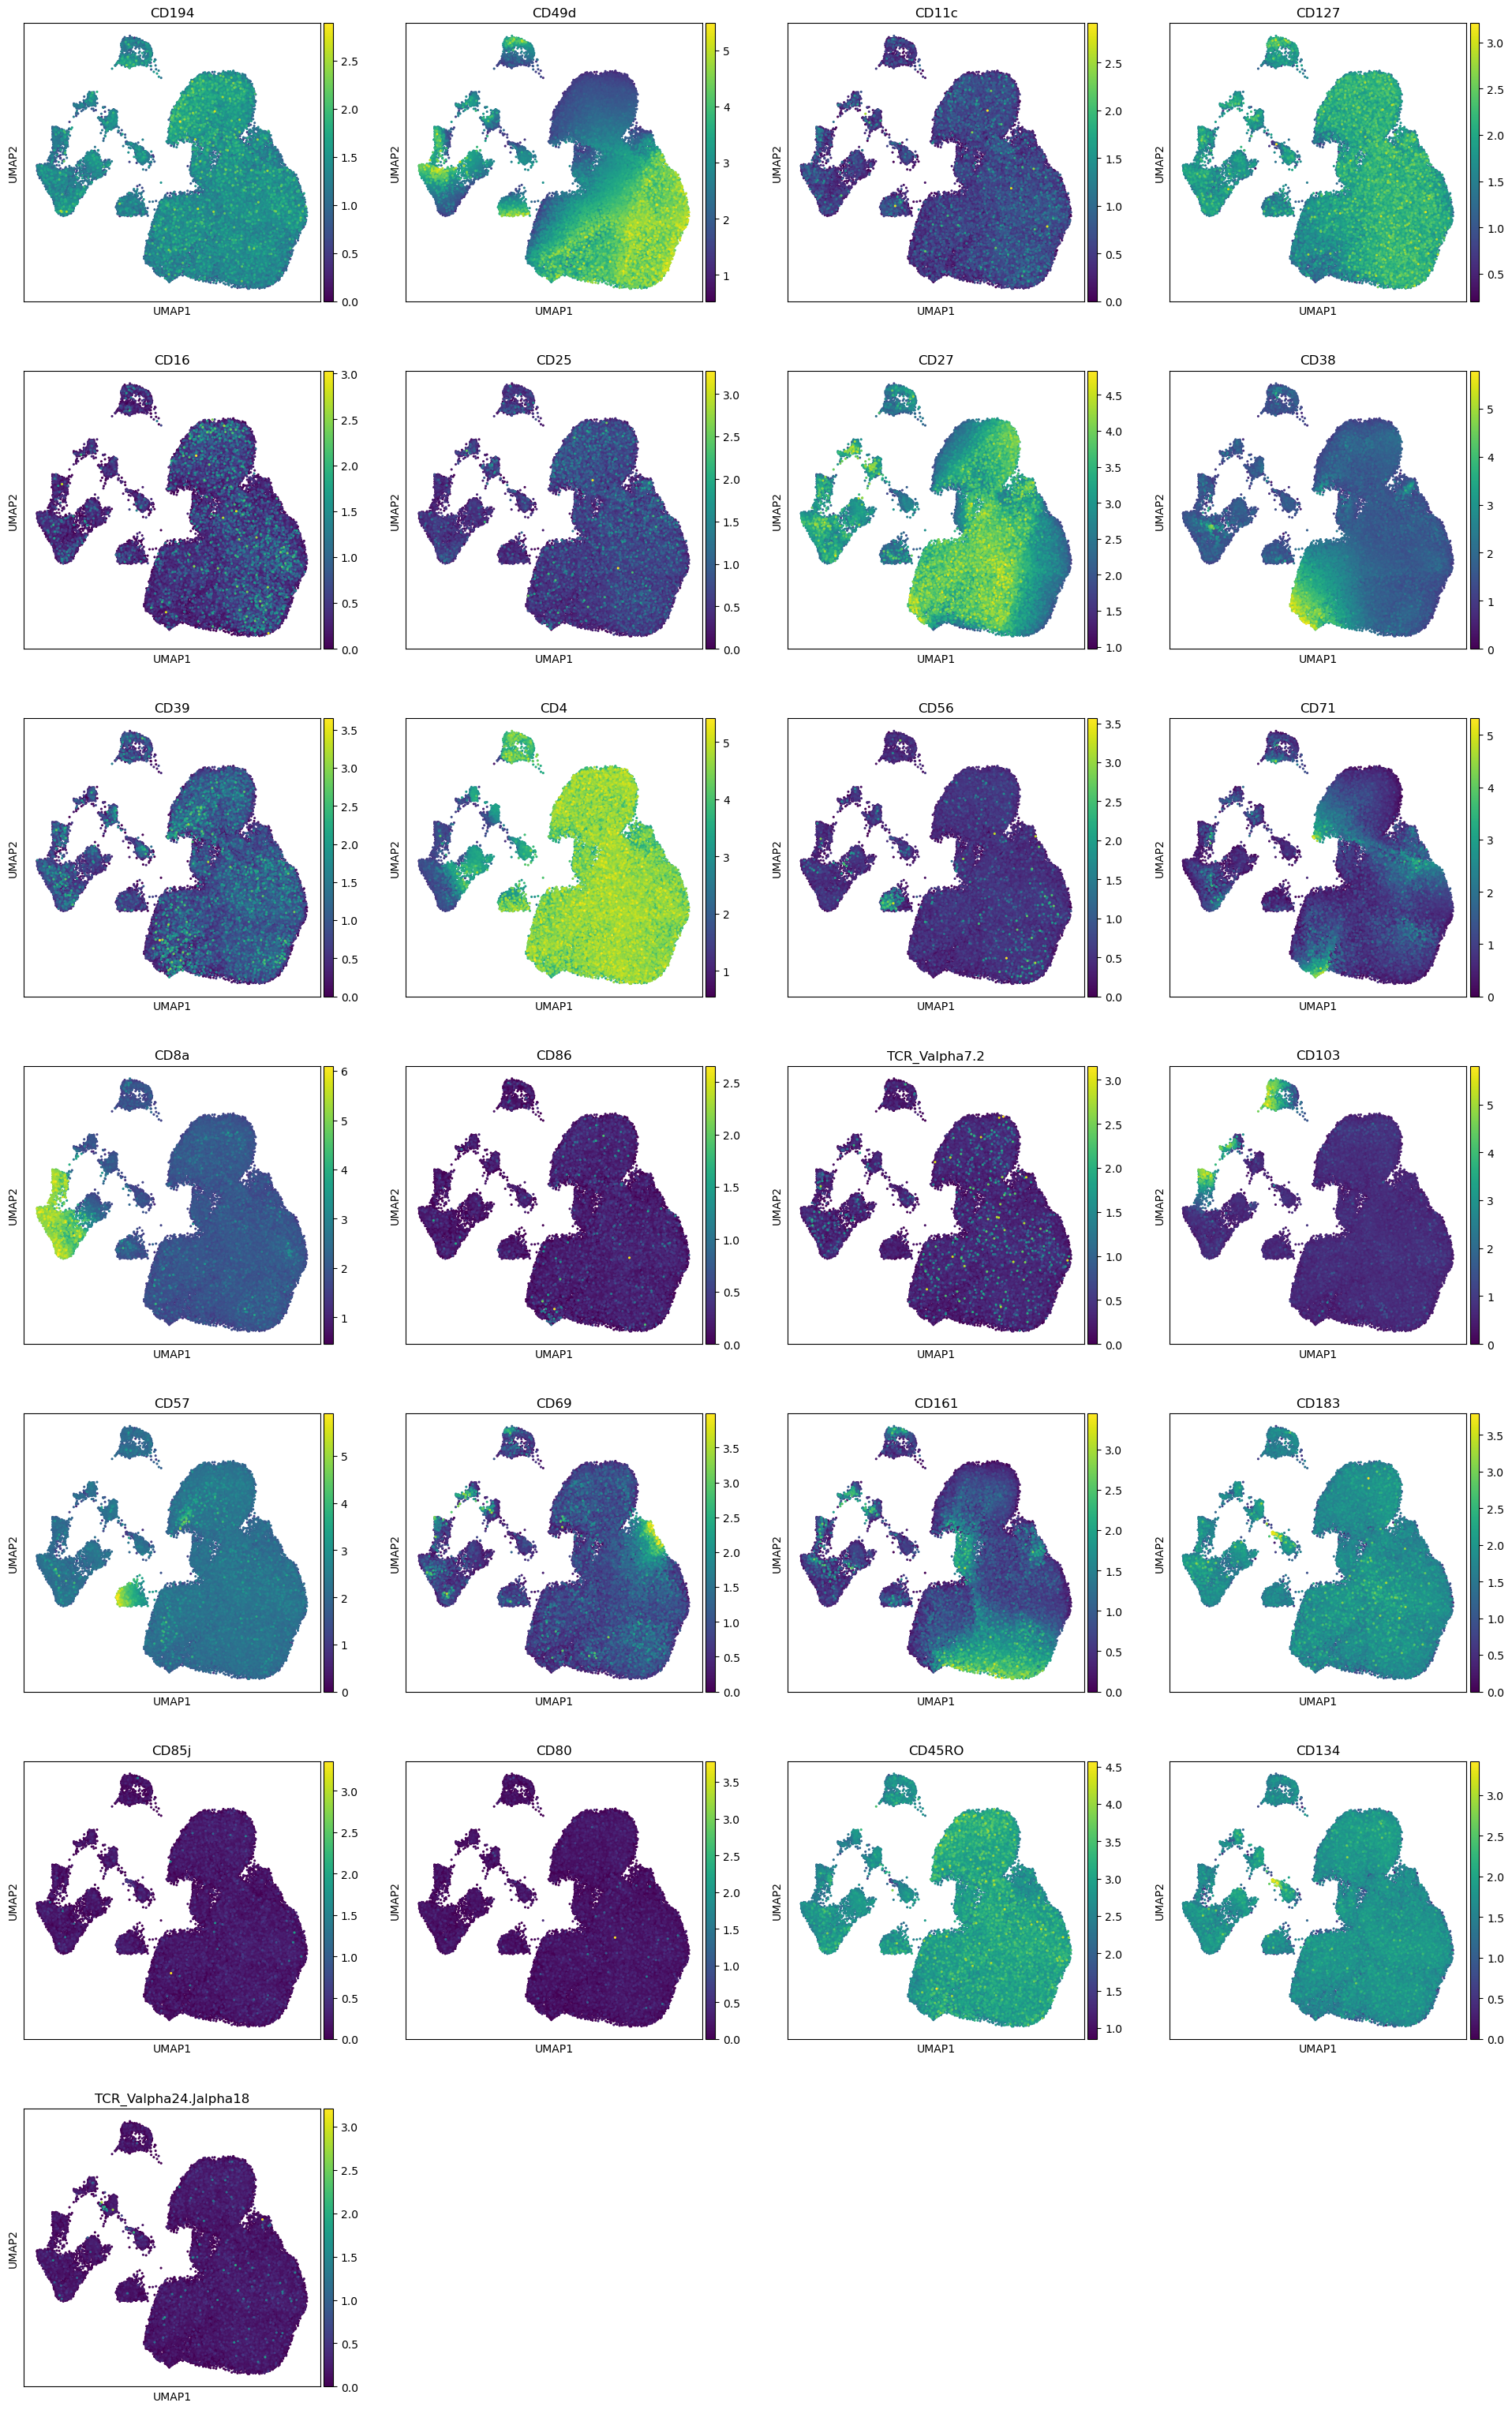

In [75]:
sc.pl.umap(adata_adt_filtered, 
           color=adata_adt_filtered.var_names,
           size=20,
           use_raw=False)

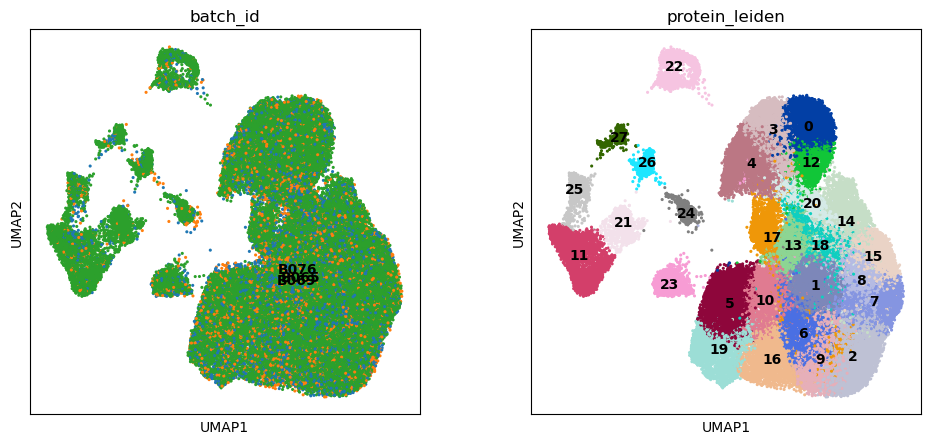

In [79]:
sc.pl.umap(adata_adt_filtered, color=['batch_id','protein_leiden',"AIFI_L3"], legend_loc='on data',use_raw=False,size=20)

In [80]:
adata_adt_filtered=adata_adt_filtered[adata_adt_filtered.obs['protein_leiden']!='11']
adata_adt_filtered=adata_adt_filtered[adata_adt_filtered.obs['protein_leiden']!='21']
adata_adt_filtered=adata_adt_filtered[adata_adt_filtered.obs['protein_leiden']!='25']


In [81]:
adata_adt_filtered=adata_adt_filtered.raw.to_adata()
adata_adt_filtered.raw=adata_adt_filtered
adata_adt_filtered=clr_normalize_each_cell(adata_adt_filtered)
sc.pp.highly_variable_genes(adata_adt_filtered,    n_top_genes=35)
adata_adt_filtered = adata_adt_filtered[:, adata_adt_filtered.var.highly_variable]
sc.pp.pca(adata_adt_filtered, n_comps=10)
sce.pp.harmony_integrate(adata_adt_filtered, 'batch_id',max_iter_harmony = 50)
sc.pp.neighbors(adata_adt_filtered, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=10)
sc.tl.umap(adata_adt_filtered)
sc.tl.leiden(adata_adt_filtered,
             resolution=1.2,
             key_added="protein_leiden")

/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
2025-01-09 17:12:15,858 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-09 17:12:18,423 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-09 17:12:18,676 - harmonypy - INFO - Iteration 1 of 50
2025-01-09 17:12:30,697 - harmonypy - INFO - Iteration 2 of 50
2025-01-09 17:12:42,569 - harmonypy - INFO - Iteration 3 of 50
2025-01-09 17:12:54,486 - harmonypy - INFO - Iteration 4 of 50
2025-01-09 17:13:06,310 - harmonypy - INFO - Iteration 5 of 50
2025-01-09 17:13:18,159 - harmonypy - INFO - Iteration 6 of 50
2025-01-09 17:13:30,072 - harmonypy - INFO - Iteration 7 of 50
2025-01-09 17:13:41,947 - harmonypy - INFO - Iteration 8 of 50
2025-01-09 17:13:54,313 - harmonypy - INFO - Iteration 9 of 50
2025-01-09 17

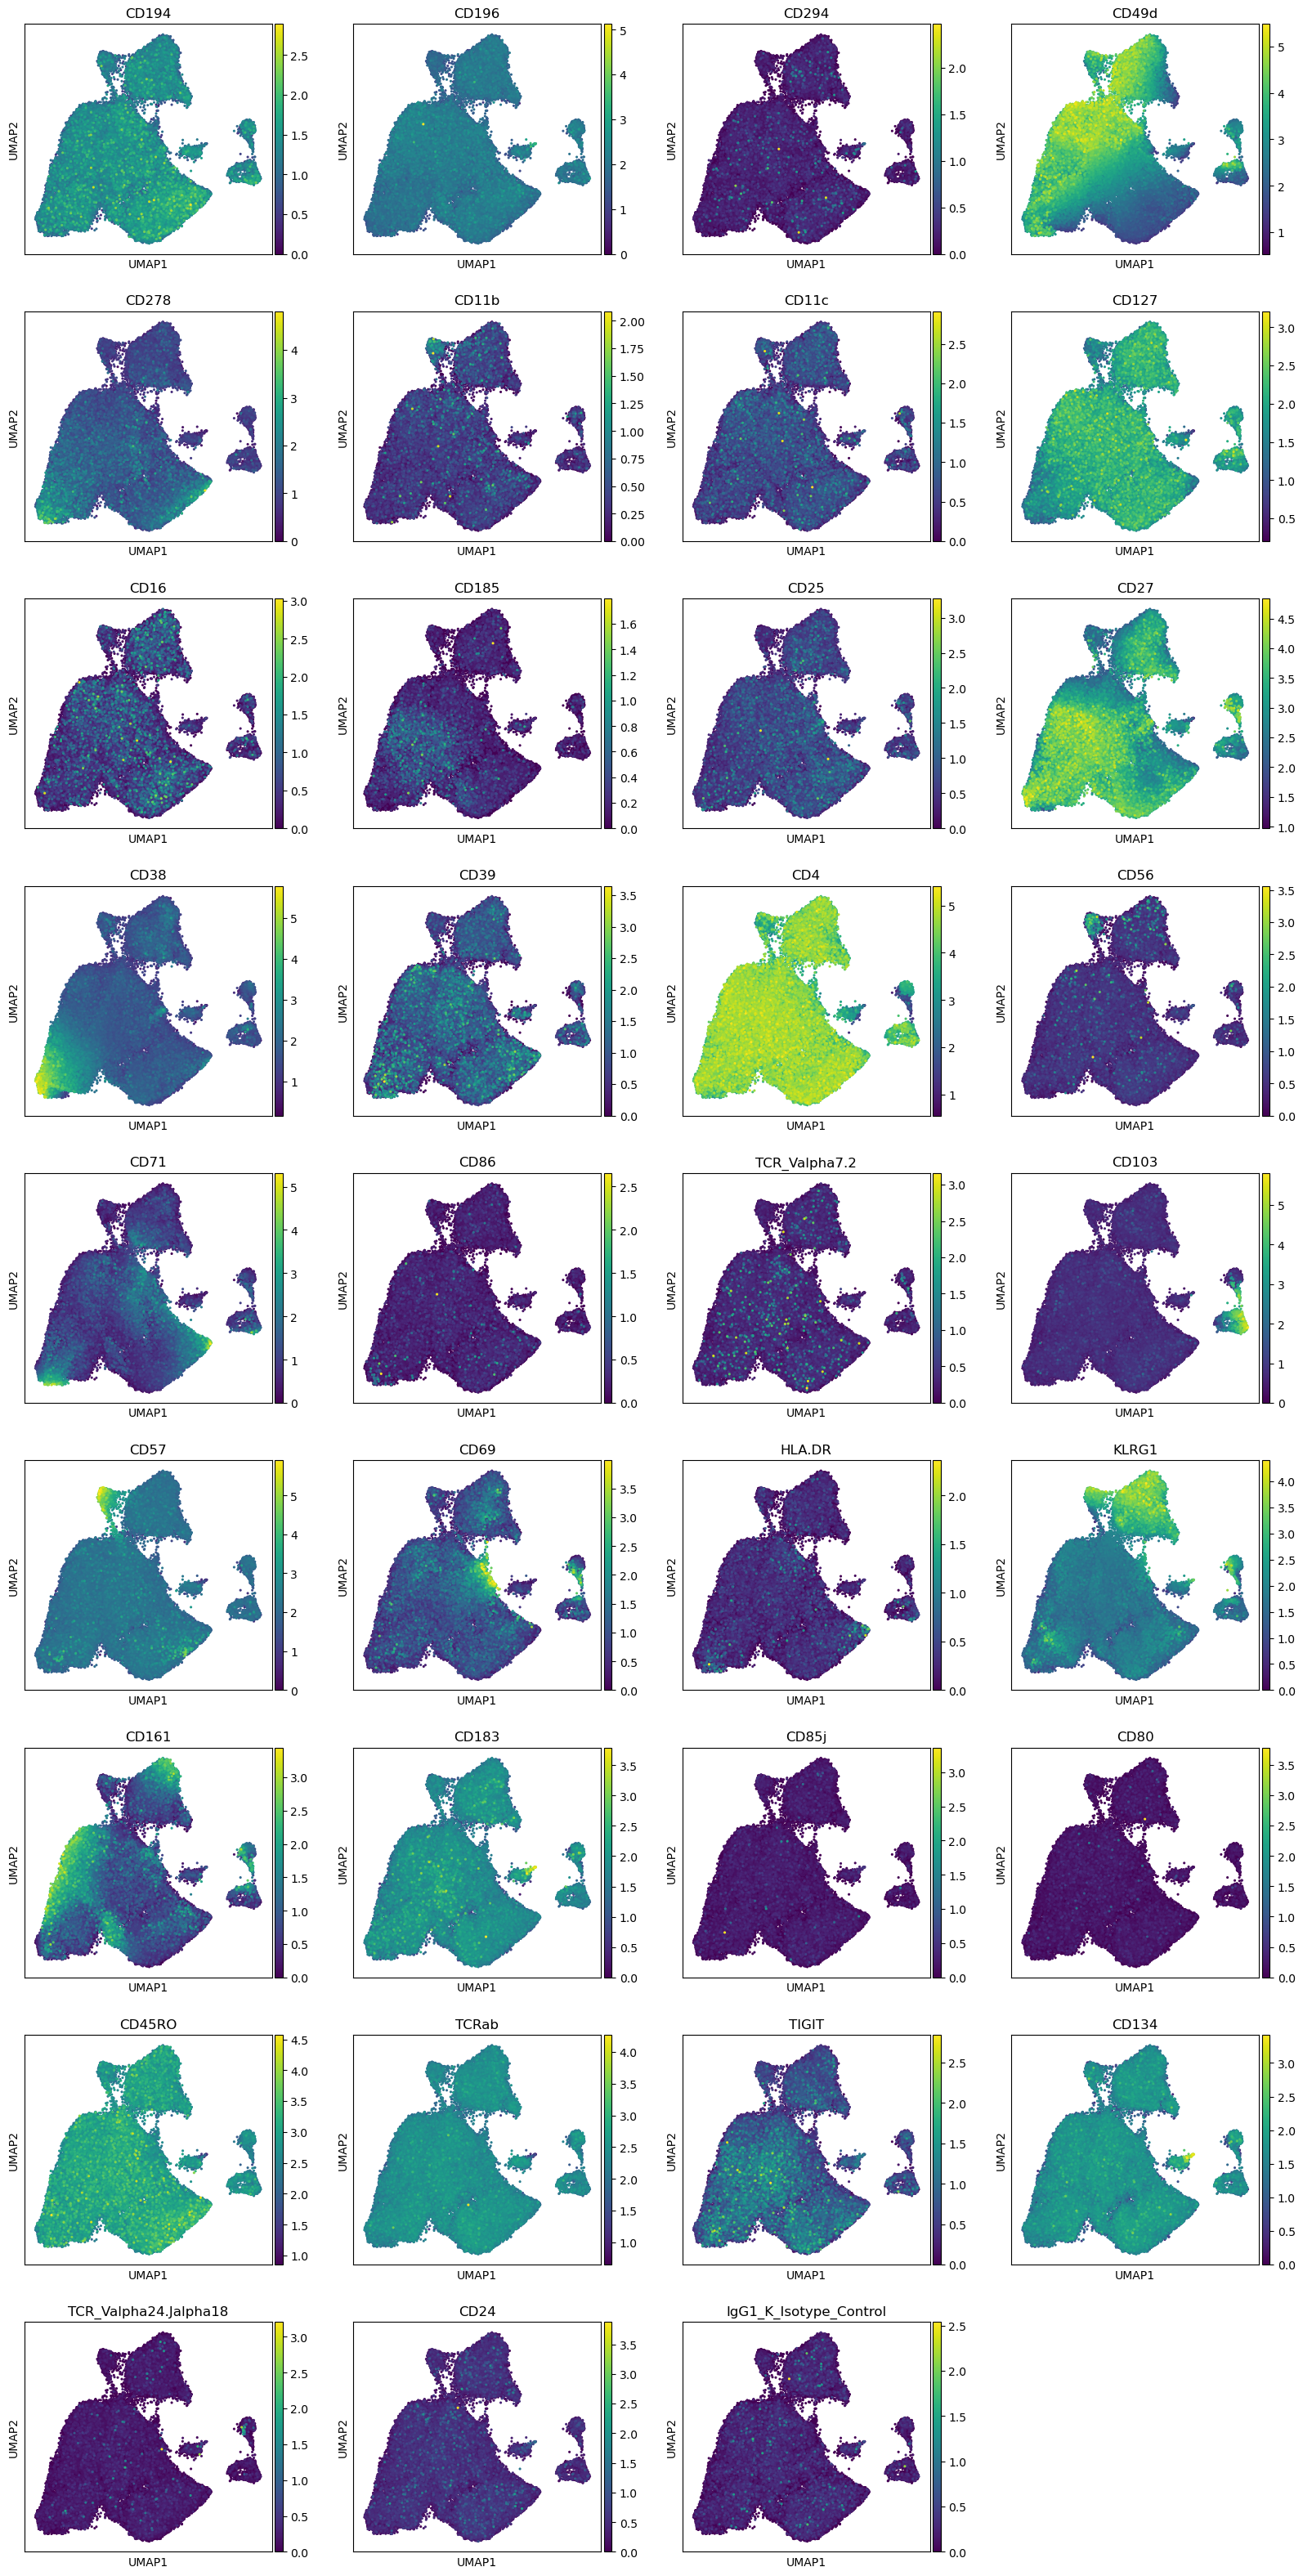

In [82]:
plt.rcParams['figure.figsize'] = [4, 4]

sc.pl.umap(adata_adt_filtered,
           color=adata_adt_filtered.var_names,
           size=20,
           use_raw=False)

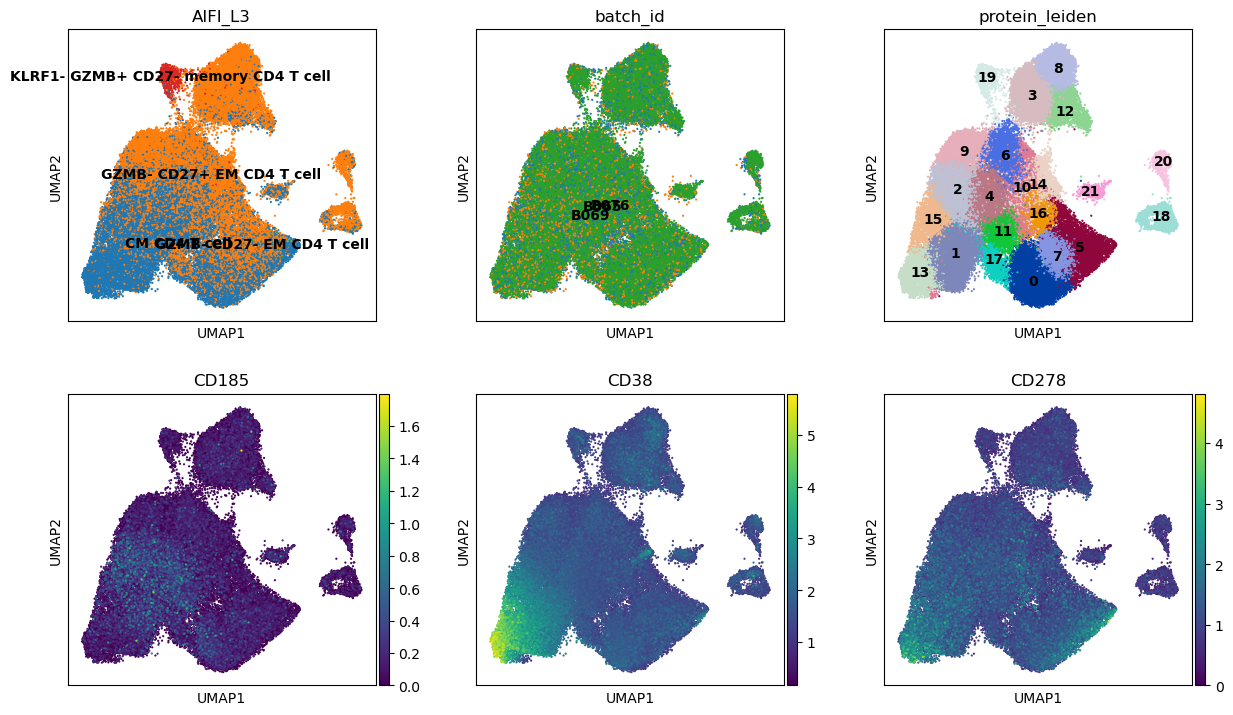

In [87]:
sc.pl.umap(adata_adt_filtered, ncols=3, color=["AIFI_L3",'batch_id','protein_leiden',
                                      'CD185',"CD38",'CD278'], legend_loc='on data',
           use_raw=False,size=10)

In [89]:
adata_adt_filtered.write_h5ad('ADT.h5ad')